# Project 15.32: Overcoming critical slowing down

Author: Tianlu Liu, YiTao Huang

Date: June 2024

Environment: Python 3.13, C++17

----

Project 15.32 primarily focuses on addressing the "critical slowing down" problem encountered when simulating the Ising model near its critical point using Monte Carlo methods.

As the system approaches the critical temperature $T_c$, the correlation length $\xi(T)$ increases sharply as

$$
\xi(T) \sim L \sim |T - T_c|^{-\nu}
$$

with $\nu = 1$ for the two-dimensional Ising model. The autocorrelation time $\tau(T)$ is given by

$$
\tau(T) \sim \xi(T)^z \sim |T - T_c|^{-z\nu}
$$

where $z \approx 2.167$ for single-spin-flip update.

This leads to a significant drop in efficiency for conventional local dynamics algorithms—such as the Metropolis single-spin-flip update when the temperature is close to $T_c$ or the system size $L$ grows.

The goal of this project is to explore and implement a cluster-flipping algorithms (Wolff algorithm), which simultaneously flip groups of correlated spins to effectively mitigate critical slowing down. This approach aims to enhance simulation efficiency and enable the study of both static and dynamic properties of the two-dimensional Ising model.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from tqdm import tqdm
from ising_model import *


plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'sans-serif'


J_val = 1.0  # ferromagnetic case
k_B = 1.0 # normalize Boltzmann constant

The Wolff algorithm has been implemented in C++, here just gives the cardinal procedures (in the view of programming):
1. Creat a set *cluster* and a deque *check*, both initialized as empty
2. Randomly select a spin as the seed, add it to both *cluster* and *check*
3. While *check* is not empty:
   1. Pop the first spin from *check* as *current*
   2. Consider the four nearest neighbors of *current* as *neighbors*
   3. For each *neighbor* in *neighbors*, if *neighbor* has **the same spin** as *current* and is not in *cluster*, add it to *cluster* and the tail of *check* with probability
    $$P_{\text{add}} = 1 - e^{-2J/k_BT}$$
4. Flip all spins in *cluster*

Steps 1-4 constitute one Wolff update. Repeat for sufficient times to achieve equilibrium configuration.

## A simple comparison

Since the autocorrelation time is needed immediately in the sampling process, we first define the autocorrelation function and the autocorrelation time below. The scaling law of the autocorrelation time will be discussed later.

The autocorrelation function $C(t)$ for a time series of measurements $O_i$ is defined as:

$$
C(t) = \frac{\langle O_i O_{i+t} \rangle - \langle O_i \rangle^2}{\langle O_i^2 \rangle - \langle O_i \rangle^2}
$$

The autocorrelation time $\tau$ is then defined as the integral of the autocorrelation function:

$$
\tau = \sum_{t=1} C(t)
$$

and Tthe sum is cut off at the first negative value of $C(t)$.

In [14]:
@njit
def autocorr(x):
    n = len(x)
    x_mean = np.mean(x)
    c0 = np.sum((x - x_mean) ** 2) / n
    acf = np.zeros(n)
    for lag in range(n):
        c_lag = np.sum((x[:n - lag] - x_mean) * (x[lag:] - x_mean)) / n
        acf[lag] = c_lag / c0
    return acf

@njit
def integrated_autocorr_time(acf):
    tau = 0.5  # Start with the zero lag
    for lag in range(1, len(acf)):
        if acf[lag] <= 0:
            break
        tau += acf[lag]
    return tau

To facilitate simulation more conveniently, we encapsulate the simplest multiple-flip process with three components: thermalization, measurement, and sampling based on the autocorrelation time.

In [15]:
def sim_ising(s, kBT, n_therm, n_meas, method = "metropolis", tau = 1):
    multipleSteps(s, kBT, n_therm, method, False)
    e_seq, m_seq, cluster_sizes = multipleSteps(s, kBT, n_meas, method, True)
    e_samples = e_seq[::tau]
    m_samples = m_seq[::tau]
    return e_samples, m_samples, cluster_sizes

In [ ]:
L = 16
T = np.arange(2, 2.8, 0.1)

steps_wolff_thermal = 1000
steps_wolff = 3000
steps_metro_thermal = 30000
steps_metro = 90000

tau_wolff = []
tau_metropolis = []
cluster_sizes = []

pbar = tqdm(T, desc="Metropolis")
for t in pbar:
    s = IsingSpins(L, L, J_val)
    e_samples, m_samples, _ = sim_ising(s, t, steps_metro_thermal, steps_metro, method="metropolis", tau=1)
    acf_metro = autocorr(m_samples)
    tau_metro = integrated_autocorr_time(acf_metro)
    tau_metropolis.append(int(np.ceil(tau_metro)))
pbar.close()

pbar = tqdm(T, desc="Wolff")
for t in pbar:
    s = IsingSpins(L, L, J_val)
    e_samples, m_samples, cluster_size = sim_ising(s, t, steps_wolff_thermal, steps_wolff, method="wolff", tau=1)
    acf_wolff = autocorr(m_samples)
    tau_wolff_val = integrated_autocorr_time(acf_wolff)
    tau_wolff.append(int(np.ceil(tau_wolff_val)))
    cluster_sizes.append(cluster_size)
pbar.close()

print('tau_metropolis:\n', tau_metropolis)
print('tau_wolff:\n', tau_wolff)
print('cluster_sizes:\n', cluster_sizes)

Wolff: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

tau_metropolis:
 [1107, 3797, 1937, 2861, 5413, 2845, 2853, 1928]
tau_wolff:
 [2, 2, 3, 3, 3, 3, 3, 3]
cluster_sizes:
 [212, 197, 164, 125, 81, 53, 34, 24]


From the results below, it is evident that the Wolff algorithm is significantly more efficient than the Metropolis algorithm, especially near the critical temperature. As we can see
$$
\tau_{\text{metro}} > 10 L^2
$$
around $T_c$. In contrast, the Wolff algorithm maintains a much lower autocorrelation time. In single spin flip view, autocorr time of Wolff can be written as 
$$
\tau_{\text{wolff, single}} = \tau_{\text{wolff}}\times p \approx L^2
$$

where $p$ is the average cluster size.

In the simulations below, for the Wolff algorithm, we perform thermalization over $60\tau_{\text{wolff}}$, followed by $3000\tau_{\text{wolff}}$ of evolution and measurement in the thermalized state, sampling every $2\tau_{\text{wolff}}$, this ensures that the samples are essentially independent.

For the Metropolis algorithm, the choices for thermalization and sampling intervals are identical to those used in the Wolff algorithm; however, the total evolution time for measurements is set to $3000\tau_{\text{wolff}}\times p_{\text{size}}$, sothat they have the same total number of spin flips.


In [ ]:
data_metro = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
}

data_wolff = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
    'cluster_size': [],
}

#---- metropolis simulation ----#
pbar = tqdm(T, desc='Metropolis')
for t in pbar:
    i = np.where(T == t)[0][0]
    cluster_size = cluster_sizes[i]

    steps_metro_themal = 60 * tau_metropolis[i]
    steps_metro = 3000 * tau_wolff[i] * cluster_sizes[i]

    s = IsingSpins(L, L, J_val)
    e_sam, m_sam, _ = sim_ising(s, k_B * t, steps_metro_themal, steps_metro, 'metropolis', 2*tau_metropolis[i])

    data_metro['energy'].append(np.mean(e_sam))
    data_metro['energy_std'].append(np.std(e_sam))
    data_metro['magnetization'].append(np.mean(m_sam))
    data_metro['magnetization_std'].append(np.std(m_sam))
pbar.close()

#---- wolff simulation ----#
pbar = tqdm(T, desc='Wolff')
for t in pbar:
    i = np.where(T == t)[0][0]

    steps_wolff_thermal = 60 * tau_wolff[i]
    steps_wolff = 3000 * tau_wolff[i]

    s_w = IsingSpins(L, L, J_val)
    e_sam, m_sam, cluster_size = sim_ising(s_w, k_B * t, steps_wolff_thermal, steps_wolff, 'wolff', 2 * tau_wolff[i])
    
    data_wolff['energy'].append(np.mean(e_sam))
    data_wolff['energy_std'].append(np.std(e_sam))
    data_wolff['magnetization'].append(np.mean(m_sam))
    data_wolff['magnetization_std'].append(np.std(m_sam))
    data_wolff['cluster_size'].append(cluster_size)
pbar.close()

Wolff: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


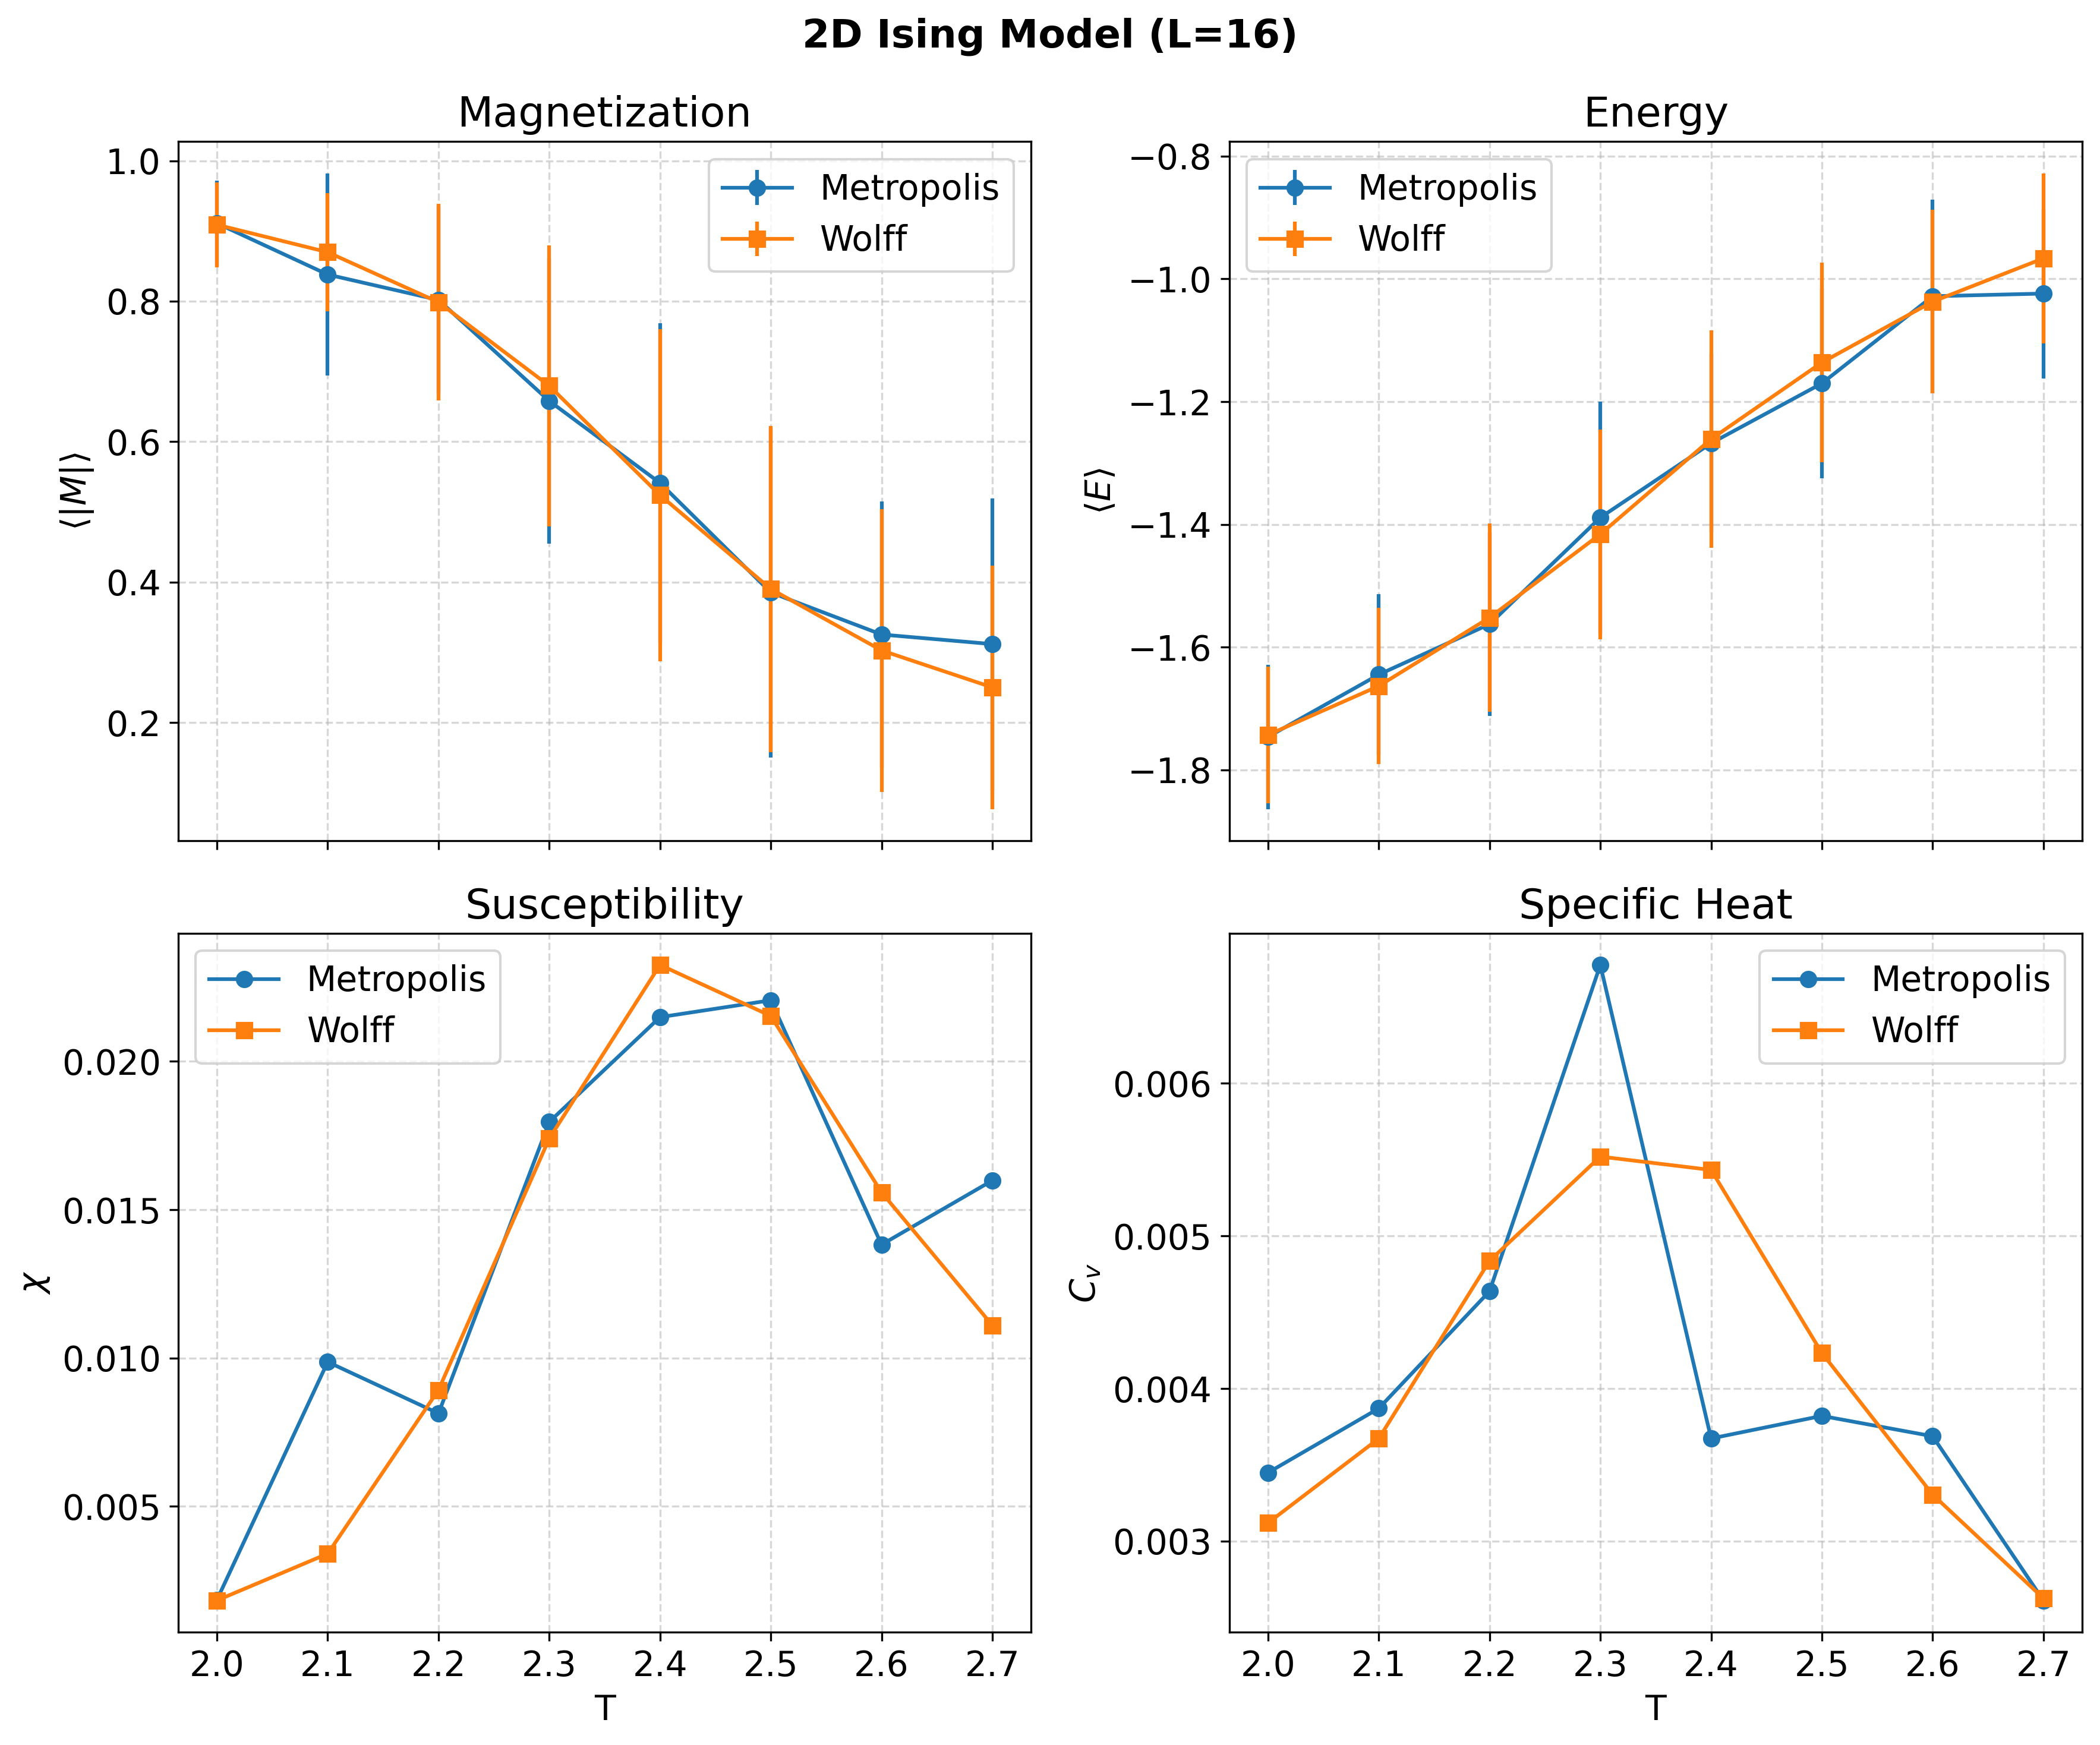

In [33]:
data_metro['T'] = T
data_metro['chi'] = (np.array(data_metro['magnetization_std'])**2) / (k_B * T)
data_metro['Cv'] = (np.array(data_metro['energy_std'])**2) / (k_B * T**2)
data_wolff['T'] = T
data_wolff['chi'] = (np.array(data_wolff['magnetization_std'])**2) / (k_B * T)
data_wolff['Cv'] = (np.array(data_wolff['energy_std'])**2) / (k_B * T**2)


fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300, sharex=True)
axs[0, 0].errorbar(data_metro['T'], data_metro['magnetization'], yerr=data_metro['magnetization_std'], label='Metropolis', fmt='o-')
axs[0, 0].errorbar(data_wolff['T'], data_wolff['magnetization'], yerr=data_wolff['magnetization_std'], label='Wolff', fmt='s-')
axs[0, 0].set_ylabel(r'$\langle |M| \rangle$')
axs[0, 0].set_title('Magnetization')
axs[0, 0].grid(ls='--', alpha=0.5)
axs[0, 0].legend()

axs[0, 1].errorbar(data_metro['T'], data_metro['energy'], yerr=data_metro['energy_std'], label='Metropolis', fmt='o-')
axs[0, 1].errorbar(data_wolff['T'], data_wolff['energy'], yerr=data_wolff['energy_std'], label='Wolff', fmt='s-')
axs[0, 1].set_ylabel(r'$\langle E \rangle$')
axs[0, 1].set_title('Energy')
axs[0, 1].grid(ls='--', alpha=0.5)
axs[0, 1].legend()


axs[1, 0].plot(data_metro['T'], data_metro['chi'], 'o-', label='Metropolis')
axs[1, 0].plot(data_wolff['T'], data_wolff['chi'], 's-', label='Wolff')
axs[1, 0].set_xlabel('T')
axs[1, 0].set_ylabel(r'$\chi$')
axs[1, 0].set_title('Susceptibility')
axs[1, 0].grid(ls='--', alpha=0.5)
axs[1, 0].legend()

axs[1, 1].plot(data_metro['T'], data_metro['Cv'], 'o-', label='Metropolis')
axs[1, 1].plot(data_wolff['T'], data_wolff['Cv'], 's-', label='Wolff')
axs[1, 1].set_xlabel('T')
axs[1, 1].set_ylabel(r'$C_v$')
axs[1, 1].set_title('Specific Heat')
axs[1, 1].grid(ls='--', alpha=0.5)
axs[1, 1].legend()

fig.suptitle(f'2D Ising Model (L={L})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

It can be seen that, under the same total number of spin flips, the Wolff algorithm yields more stable results—both for first-order quantities (energy and magnetization) and second-order quantities (magnetic susceptibility and specific heat).

## Critical exponents

The finite-size scaling theroy gives (around $T_c$):
$$
\begin{aligned}
m &\sim L^{-\beta/\nu} \\
c &\sim L^{\alpha/\nu} \\
\chi &\sim L^{\gamma/\nu}
\end{aligned}
$$


In [41]:
L = np.array([4, 8, 16, 32]) 
Tc = 2/np.log(1 + np.sqrt(2))
print('Critical Temperature:', Tc)

Critical Temperature: 2.269185314213022


Similarly, we first estimate the autocorrelation time $\tau$ at $T_c$ for different system sizes $L = [4, 8, 16, 32]$.

In [39]:
steps_wolff_thermal = 1000
steps_wolff = 3000

tau_wolff_L = []
tau_metropolis_L = []
cluster_sizes_L = []

pbar = tqdm(L, desc="Metropolis")
for l in pbar:
    s = IsingSpins(l, l, J_val)
    steps_metro_thermal = 100 * l **2
    steps_metro = 400 * l **2
    e_samples, m_samples, _ = sim_ising(s, Tc, steps_metro_thermal, steps_metro, method="metropolis", tau=1)
    acf_metro = autocorr(m_samples)
    tau_metro = integrated_autocorr_time(acf_metro)
    tau_metropolis_L.append(int(np.ceil(tau_metro)))
pbar.close()

pbar = tqdm(L, desc="Wolff")
for l in pbar:
    s = IsingSpins(l, l, J_val)
    e_samples, m_samples, cluster_size = sim_ising(s, Tc, steps_wolff_thermal, steps_wolff, method="wolff", tau=1)
    acf_wolff = autocorr(m_samples)
    tau_wolff_val = integrated_autocorr_time(acf_wolff)
    tau_wolff_L.append(int(np.ceil(tau_wolff_val)))
    cluster_sizes_L.append(cluster_size)
pbar.close()

print('tau_metropolis:\n', tau_metropolis_L)
print('tau_wolff:\n', tau_wolff_L)
print('cluster_sizes:\n', cluster_sizes_L)

Wolff: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

tau_metropolis:
 [33, 219, 10093, 62226]
tau_wolff:
 [2, 2, 3, 3]
cluster_sizes:
 [12, 41, 140, 474]


In [ ]:
data_metro_L = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
}

data_wolff_L = {
    'energy': [],
    'energy_std': [],
    'magnetization': [],
    'magnetization_std': [],
    'cluster_size': [],
}

#---- metropolis simulation ----#
pbar = tqdm(L, desc='Metropolis')
for l in pbar:
    i = np.where(L == l)[0][0]
    cluster_size = cluster_sizes_L[i]

    steps_metro_themal = 60 * tau_metropolis_L[i]
    steps_metro = 3000 * tau_wolff_L[i] * cluster_sizes_L[i]

    s = IsingSpins(l, l, J_val)
    e_sam, m_sam, _ = sim_ising(s, k_B * t, steps_metro_themal, steps_metro, 'metropolis', 2*tau_metropolis_L[i])

    data_metro_L['energy'].append(np.mean(e_sam))
    data_metro_L['energy_std'].append(np.std(e_sam))
    data_metro_L['magnetization'].append(np.mean(m_sam))
    data_metro_L['magnetization_std'].append(np.std(m_sam))
pbar.close()

#---- wolff simulation ----#
pbar = tqdm(L, desc='Wolff')
for l in pbar:
    i = np.where(L == l)[0][0]

    steps_wolff_thermal = 60 * tau_wolff_L[i]
    steps_wolff = 3000 * tau_wolff_L[i]

    s_w = IsingSpins(l, l, J_val)
    e_sam, m_sam, cluster_size = sim_ising(s_w, k_B * t, steps_wolff_thermal, steps_wolff, 'wolff', 2 * tau_wolff_L[i])
    
    data_wolff_L['energy'].append(np.mean(e_sam))
    data_wolff_L['energy_std'].append(np.std(e_sam))
    data_wolff_L['magnetization'].append(np.mean(m_sam))
    data_wolff_L['magnetization_std'].append(np.std(m_sam))
    data_wolff_L['cluster_size'].append(cluster_size)
pbar.close()

data_metro_L['L'] = L
data_metro_L['chi'] = (np.array(data_metro_L['magnetization_std'])**2) / (k_B * Tc)
data_metro_L['Cv'] = (np.array(data_metro_L['energy_std'])**2) / (k_B * Tc**2)

data_wolff_L['L'] = L
data_wolff_L['chi'] = (np.array(data_wolff_L['magnetization_std'])**2) / (k_B * Tc)
data_wolff_L['Cv'] = (np.array(data_wolff_L['energy_std'])**2) / (k_B * Tc**2)

Metropolis:   0%|          | 0/4 [00:00<?, ?it/s]